<h1>
<center>Neuron Networks & Sector Rotation</center>
</h1>

# Packages and Data

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 378 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15192 sha256=1844a21cd560a2503faaf5dbe3fea5826555f4cda14ee5f545475a55aec15b3e
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


In [3]:
pip install fredapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential, layers
import yfinance as yahooFinance
from yahoofinancials import YahooFinancials
from fredapi import Fred
import datetime as datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
import seaborn as sns
import cvxopt as opt
from cvxopt import blas, solvers

The following code is to import the data from Yahoo.

In [5]:
def import_fin(ticker):
    data = pd.DataFrame(YahooFinancials(ticker).get_historical_price_data(start_date='1901-01-01',
                                                                    end_date='2022-06-30',
                                                                    time_interval='daily')[ticker]['prices']).drop('date', axis=1).set_index('formatted_date')
    price = data['close']
    price.index = pd.to_datetime(price.index)
    
    return price

vnq = import_fin("VNQ")
xlk = import_fin("XLK")
xlf = import_fin("XLF")
xlv = import_fin("XLV")
xle = import_fin("XLE")
xly = import_fin("XLY")
xli = import_fin("XLI")
xlc = import_fin("XLC")
xlp = import_fin("XLP")
xlu = import_fin("XLU")
xlb = import_fin("XLB")

## Predicting Prices Using neuron network

The method that we are using is sensitive to scaling, so I decided to apply the maxmon scaling to keep the data in between 0 and 1.

In [6]:
def scale_maxmin(x):
    x_scaled = (x-np.min(x))/(np.max(x)-np.min(x))
    return x_scaled

def unscale_maxmin(x_scaled,x):
    x_unscaled = x_scaled*(np.max(x)-np.min(x))+np.min(x)
    return x_unscaled

In [7]:
vnq_maxmin = scale_maxmin(vnq)
xlk_maxmin = scale_maxmin(xlk)
xlf_maxmin = scale_maxmin(xlf)
xlv_maxmin = scale_maxmin(xlv)
xle_maxmin = scale_maxmin(xle)
xly_maxmin = scale_maxmin(xly)
xli_maxmin = scale_maxmin(xli)
xlc_maxmin = scale_maxmin(xlc)
xlp_maxmin = scale_maxmin(xlp)
xlu_maxmin = scale_maxmin(xlu)
xlb_maxmin = scale_maxmin(xlb)

I'm predicting the price using time series, and the following code is to form a time series matrix.

In [8]:
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

In [9]:
X_vnq, y_vnq = ts_split(vnq_maxmin)
X_xlk, y_xlk = ts_split(xlk_maxmin)
X_xlf, y_xlf = ts_split(xlf_maxmin)
X_xlv, y_xlv = ts_split(xlv_maxmin)
X_xle, y_xle = ts_split(xle_maxmin)
X_xly, y_xly = ts_split(xly_maxmin)
X_xli, y_xli = ts_split(xli_maxmin)
X_xlc, y_xlc = ts_split(xlc_maxmin)
X_xlp, y_xlp = ts_split(xlp_maxmin)
X_xlu, y_xlu = ts_split(xlu_maxmin)
X_xlb, y_xlb = ts_split(xlb_maxmin)

Also, need to separate between training set ans test set.

In [10]:
n = round(len(xlk)/2)
X_vnq_train, y_vnq_train = X_vnq[:round(len(vnq)/2)], y_vnq[:round(len(vnq)/2)]
X_xlk_train, y_xlk_train = X_xlk[:n], y_xlk[:n]
X_xlf_train, y_xlf_train = X_xlf[:n], y_xlf[:n]
X_xlv_train, y_xlv_train = X_xlv[:n], y_xlv[:n]
X_xle_train, y_xle_train = X_xle[:n], y_xle[:n]
X_xly_train, y_xly_train = X_xly[:n], y_xly[:n]
X_xli_train, y_xli_train = X_xli[:n], y_xli[:n]
X_xlc_train, y_xlc_train = X_xlc[:round(len(xlc)/2)], y_xlc[:round(len(xlc)/2)]
X_xlp_train, y_xlp_train = X_xlp[:n], y_xlp[:n]
X_xlu_train, y_xlu_train = X_xlu[:n], y_xlu[:n]
X_xlb_train, y_xlb_train = X_xlb[:n], y_xlb[:n]

X_vnq_test, y_vnq_test = X_vnq[round(len(vnq)/2):], y_vnq[round(len(vnq)/2):]
X_xlk_test, y_xlk_test = X_xlk[n:], y_xlk[n:]
X_xlf_test, y_xlf_test = X_xlf[n:], y_xlf[n:]
X_xlv_test, y_xlv_test = X_xlv[n:], y_xlv[n:]
X_xle_test, y_xle_test = X_xle[n:], y_xle[n:]
X_xly_test, y_xly_test = X_xly[n:], y_xly[n:]
X_xli_test, y_xli_test = X_xli[n:], y_xli[n:]
X_xlc_test, y_xlc_test = X_xlc[round(len(xlc)/2):], y_xlc[round(len(xlc)/2):]
X_xlp_test, y_xlp_test = X_xlp[n:], y_xlp[n:]
X_xlu_test, y_xlu_test = X_xlu[n:], y_xlu[n:]
X_xlb_test, y_xlb_test = X_xlb[n:], y_xlb[n:]

# Neuron Networks

I decide to use the long short-term memory method to predict the price of each ETF.

In [11]:
import random as python_random

def reset_session(seed=42):
    tf.random.set_seed(seed)
    python_random.seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [12]:
def compute_NN(X, X_train, y_train, y_test, i, j, date, ticker):
    reset_session()
    model = Sequential([
        keras.layers.LSTM(i, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(j, activation="relu", kernel_initializer="he_normal"),
        keras.layers.Dense(1)
    ],)

    model.compile(optimizer='Nadam',loss='mse')

    reset_session()
    model.fit(X_train, y_train, epochs=100,verbose=0)

    y_pred = pd.DataFrame(model.predict(X)).squeeze()
    y_pred.index = pd.to_datetime(date[-len(y_pred):])
    y_test = pd.DataFrame(y_test)
    y_test.index = date[-len(y_test):]
    y_pred_plot = y_pred[y_test.index]
    
    plt.plot(y_pred_plot, label="Prediction")
    plt.plot(y_test, label="Actual")
    plt.title(ticker)
    plt.legend()
    plt.show()
      
    return y_pred

In [13]:
date = xlc.index
ETF_list = [vnq[date], xlk[date],xlf[date],xlv[date],xle[date],xly[date],xli[date],xlc[date],xlp[date],xlu[date],xlb[date]]
name_list = ["vnq", "xlk","xlf", "xlv", "xle", "xly", "xli", "xlc", "xlp", "xlu", "xlb"]

After the prediction, we'll need to rescale the result so that it will be in original scale.

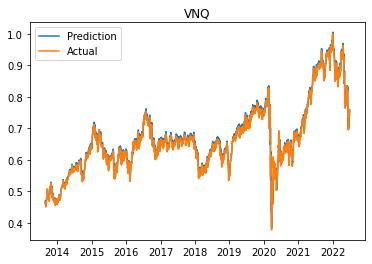

In [14]:
vnq_pred = unscale_maxmin(compute_NN(X_vnq, X_vnq_train, y_vnq_train, y_vnq_test, 70, 50, vnq.index, "VNQ"),vnq)

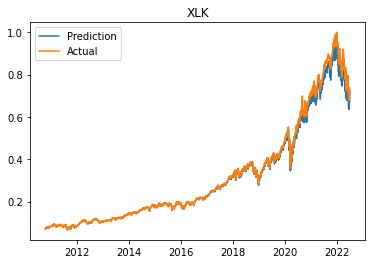

In [15]:
xlk_pred = unscale_maxmin(compute_NN(X_xlk, X_xlk_train, y_xlk_train, y_xlk_test, 70, 50, xlk.index, "XLK"),xlk)

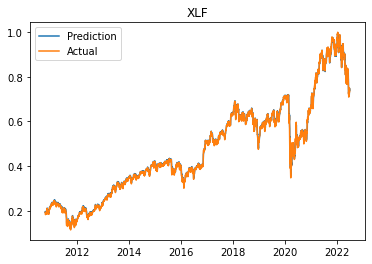

In [16]:
xlf_pred = unscale_maxmin(compute_NN(X_xlf, X_xlf_train, y_xlf_train, y_xlf_test, 70, 50, xlf.index, "XLF"),xlf)

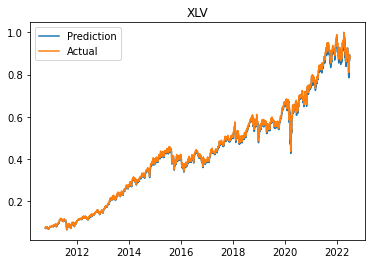

In [17]:
xlv_pred = unscale_maxmin(compute_NN(X_xlv, X_xlv_train, y_xlv_train, y_xlv_test, 75, 30, xlv.index, "XLV"),xlv)

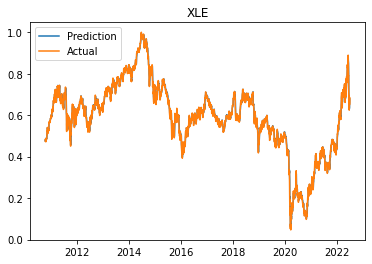

In [18]:
xle_pred = unscale_maxmin(compute_NN(X_xle, X_xle_train, y_xle_train, y_xle_test, 70, 50, xle.index, "XLE"),xle)

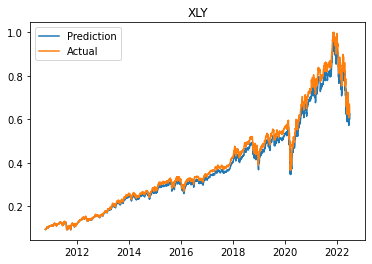

In [19]:
xly_pred = unscale_maxmin(compute_NN(X_xly, X_xly_train, y_xly_train, y_xly_test, 50, 100, xly.index, "XLY"),xly)

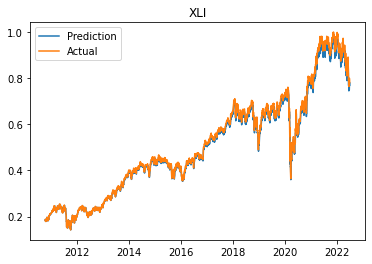

In [20]:
xli_pred = unscale_maxmin(compute_NN(X_xli, X_xli_train, y_xli_train, y_xli_test, 75, 100, xli.index, "XLI"),xli)

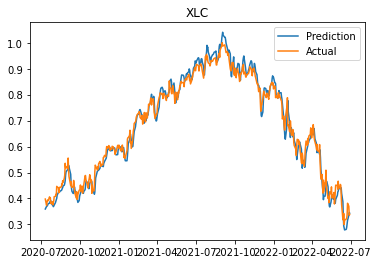

In [21]:
xlc_pred = unscale_maxmin(compute_NN(X_xlc, X_xlc_train, y_xlc_train, y_xlc_test, 45, 35, xlc.index, "XLC"),xlc)

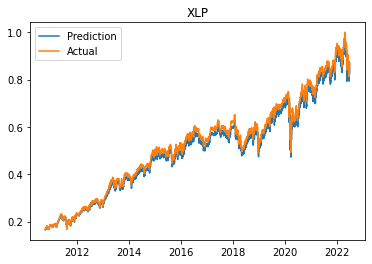

In [22]:
xlp_pred = unscale_maxmin(compute_NN(X_xlp, X_xlp_train, y_xlp_train, y_xlp_test, 50, 75, xlp.index, "XLP"),xlp)

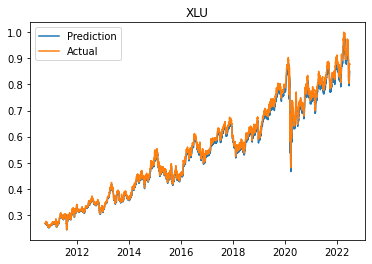

In [23]:
xlu_pred = unscale_maxmin(compute_NN(X_xlu, X_xlu_train, y_xlu_train, y_xlu_test, 125, 100, xlu.index, "XLU"),xlu)

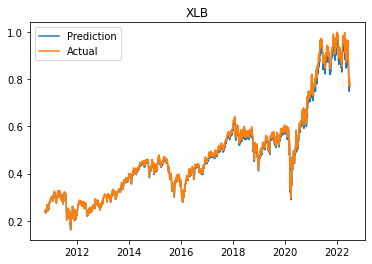

In [24]:
xlb_pred = unscale_maxmin(compute_NN(X_xlb, X_xlb_train, y_xlb_train, y_xlb_test, 50, 125, xlb.index, "XLB"),xlb)

Overall, the neuron network perform very well in term of predicting the prices of the ETFs.

# Sector Rotation

## Equally weighted portfolio

Throughout this process, we will consider and adjust the portfolio monthly. Thata is, we will ignore the changes in the middle of the month and consider the information of the prices at the end of the month. The following code will be used to extract the last trading day of each month.

In [25]:
def extract(months):
  ind = []
  for i in range(1,len(months)):
    if months[i-1] != months[i]:
      ind.append(i-1)
  ind = np.array(ind)
  return ind

In [26]:
ETF_list = [vnq, xlk,xlf,xlv,xle,xly,xli,xlc,xlp,xlu,xlb]
ETF = []
for i in range(len(ETF_list)):
    ETF.append(ETF_list[i][extract(ETF_list[i].index.month)])

In [27]:
table1 = pd.DataFrame(ETF).T
table1.columns = [k.upper() for k in name_list]
table1

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1998-12-31,NaN,32.625000,19.039398,26.000000,23.343750,26.125000,24.562500,NaN,27.156250,30.234375,21.921875
1999-01-29,NaN,37.812500,19.369415,27.250000,21.812500,27.468750,24.296875,NaN,26.796875,29.484375,21.109375
1999-02-26,NaN,34.062500,19.674046,27.281250,21.625000,27.296875,24.515625,NaN,26.515625,28.671875,21.437500
1999-03-31,NaN,36.593750,20.257919,28.000000,24.593750,28.593750,24.937500,NaN,26.437500,26.687500,21.750000
1999-04-30,NaN,36.812500,21.679529,29.000000,28.234375,29.343750,28.687500,NaN,25.515625,29.265625,27.125000
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,106.239998,161.970001,39.060001,131.229996,65.919998,184.949997,100.739998,73.949997,75.970001,69.250000,84.449997
2022-02-28,102.540001,154.070007,38.520000,129.960007,70.580002,177.429993,99.889999,68.449997,74.900002,67.930000,83.379997
2022-03-31,108.370003,158.929993,38.320000,136.990005,76.440002,185.000000,102.980003,68.779999,75.889999,74.459999,88.150002


In [28]:
date = xlc_pred.index

Pred_list = [vnq_pred.squeeze(), xlk_pred.squeeze(),xlf_pred.squeeze(),xlv_pred.squeeze(),xle_pred.squeeze(),
             xly_pred.squeeze(),xli_pred.squeeze(),xlc_pred.squeeze(),xlp_pred.squeeze(),xlu_pred.squeeze(),
             xlb_pred.squeeze()]
predict = []
for i in range(len(Pred_list)):
    predict.append(Pred_list[i][extract(Pred_list[i].index.month)])

In [29]:
table2 = pd.DataFrame(predict).T
table2.columns = [k.upper() for k in name_list]
table2

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-01-29,NaN,37.119877,19.059536,27.224144,21.957737,27.437748,24.220161,NaN,26.523653,29.454758,21.027145
1999-02-26,NaN,35.029667,19.379927,27.140675,21.845058,27.229275,24.506451,NaN,26.438347,28.487209,21.457022
1999-03-31,NaN,36.893906,20.606327,28.058119,25.094797,29.175241,25.286270,NaN,27.011257,26.778490,22.056438
1999-04-30,NaN,36.951401,22.071264,29.106319,28.609932,29.598267,29.052834,NaN,25.880581,29.506775,27.370758
1999-05-28,NaN,36.417805,20.216780,27.832666,27.514299,27.813828,27.871059,NaN,24.902527,29.492188,25.159470
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,105.910301,154.655533,38.793964,129.627884,65.723480,169.647476,97.626778,70.394775,74.594994,66.967957,81.417046
2022-02-28,104.803200,148.792358,39.208759,130.721863,68.724205,167.680069,97.238235,67.384933,75.480087,66.131775,82.401581
2022-03-31,110.223991,152.266846,39.186241,137.051392,77.579346,180.707962,102.302658,70.166527,74.375999,72.834167,87.190483


In [30]:
returns = pd.DataFrame.diff(table1)/table1.shift()
returns

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1998-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-29,NaN,0.159004,0.017333,0.048077,-0.065596,0.051435,-0.010814,NaN,-0.013234,-0.024806,-0.037063
1999-02-26,NaN,-0.099174,0.015727,0.001147,-0.008596,-0.006257,0.009003,NaN,-0.010496,-0.027557,0.015544
1999-03-31,NaN,0.074312,0.029677,0.026346,0.137283,0.047510,0.017208,NaN,-0.002946,-0.069210,0.014577
1999-04-30,NaN,0.005978,0.070176,0.035714,0.148030,0.026230,0.150376,NaN,-0.034870,0.096604,0.247126
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.084217,-0.068442,0.000256,-0.068564,0.187748,-0.095334,-0.047916,-0.048018,-0.014784,-0.032551,-0.067984
2022-02-28,-0.034827,-0.048774,-0.013825,-0.009678,0.070692,-0.040660,-0.008438,-0.074375,-0.014085,-0.019061,-0.012670
2022-03-31,0.056856,0.031544,-0.005192,0.054094,0.083026,0.042665,0.030934,0.004821,0.013218,0.096128,0.057208


We will rank the first 4 highest returns at each time point. As shown below, 1 means we select the ETF and 0 otherwise.

In [31]:
ind = []
for i in range(len(table2)):
    ret = (table2.iloc[i]-table1.iloc[i])/table1.iloc[i]
    ind.append(((-ret).rank()<5)*1)

ind = pd.DataFrame(ind)
ind.index = table2.index
ind    

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-01-29,0,1,1,1,0,1,0,0,0,0,0
1999-02-26,0,0,1,0,1,0,1,0,0,0,1
1999-03-31,0,1,1,0,1,1,0,0,0,0,0
1999-04-30,0,0,0,0,1,0,1,0,0,1,1
1999-05-28,0,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,0,0,1,0,1,0,0,0,1,1,0
2022-02-28,0,0,1,1,1,0,0,0,1,0,0
2022-03-31,1,0,0,1,1,0,0,0,0,1,0


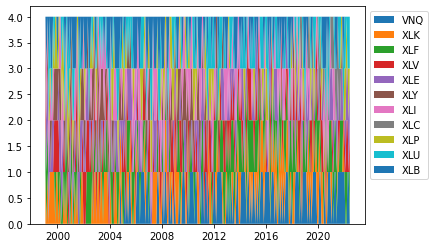

In [32]:
plt.stackplot(ind.index, ind.T.iloc[0], ind.T.iloc[1], ind.T.iloc[2],ind.T.iloc[3],ind.T.iloc[4],ind.T.iloc[5],ind.T.iloc[6],
             ind.T.iloc[7],ind.T.iloc[8],ind.T.iloc[9],ind.T.iloc[10], labels = ind.T.index)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [33]:
port1 = np.zeros(len(returns)-1)
port1[0] = 100
bnch = np.zeros(len(returns)-1)
bnch[0] = 100

for i in range(1,len(returns)-1):
    port1[i] = np.sum(port1[i-1]*(1+returns.iloc[i+1])*ind.iloc[i])/4
    bnch[i] = np.mean(bnch[i-1]*(1+returns.iloc[i+1]))

port1 = pd.DataFrame(port1).squeeze()
port1.index = ind.index
bnch = pd.DataFrame(bnch).squeeze()
bnch.index = ind.index

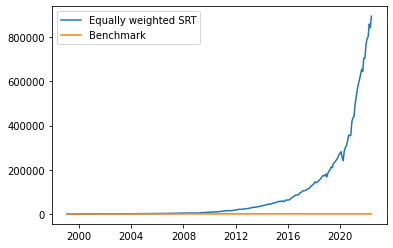

In [34]:
plt.plot(port1)
plt.plot(bnch)
plt.legend(["Equally weighted SRT","Benchmark"])
plt.show()

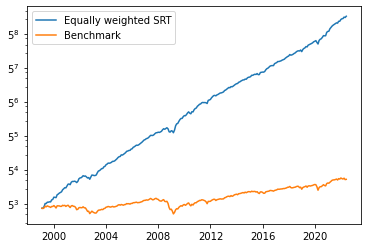

In [35]:
plt.plot(port1)
plt.plot(bnch)
plt.legend(["Equally weighted SRT","Benchmark"])
plt.yscale('log',basey=5)
plt.show()

### Performance

In [36]:
ret_port = np.diff(port1)/port1[:-1]
ret_bnch = np.diff(bnch)/bnch[:-1]

In [37]:
print(np.mean(ret_port), np.mean(ret_bnch))

0.03397653438140746 0.00585096510804225


In [38]:
print(np.std(ret_port), np.std(ret_bnch))

0.044398288686970044 0.043118850614371526


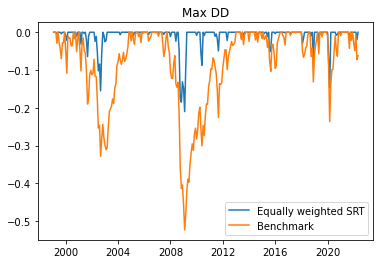

In [39]:
def DD(ret):
  dd = np.zeros(len(ret))
  dd[0] = 0
  for i in range(1,len(ret)):
    dd[i] = min(0,(1+dd[i-1])*(1+ret[i])-1)

  dd = pd.DataFrame(dd).squeeze()
  dd.index = ret.index
  return dd

plt.plot(DD(np.diff(port1)/port1[:-1]), label='Equally weighted SRT')
plt.plot(DD(np.diff(bnch)/bnch[:-1]), label='Benchmark')
plt.legend()
plt.title("Max DD")
plt.show()

In [40]:
print(np.min(DD(ret_port)), np.min(DD(ret_bnch)))

-0.20998183168473206 -0.5229911488243363


In [41]:
fred = Fred(api_key='fec003d5c966f4c13258c8476a6b4dba')
tbill3mo = fred.get_series('DGS3MO').dropna()/100/12
tbill3mo

1981-09-01    0.014175
1981-09-02    0.013875
1981-09-03    0.014133
1981-09-04    0.013867
1981-09-08    0.013783
                ...   
2022-08-11    0.002183
2022-08-12    0.002192
2022-08-15    0.002267
2022-08-16    0.002250
2022-08-17    0.002233
Length: 10241, dtype: float64

In [42]:
rf = tbill3mo[port1.index].iloc[:-1]

In [43]:
sharpe_port = np.mean(ret_port-rf) / np.std(ret_port-rf)
sharpe_bnch = np.mean(ret_bnch-rf) / np.std(ret_bnch-rf)
print(sharpe_port,sharpe_bnch)

0.7340400146476335 0.10338546559103298


In [44]:
info = np.mean(ret_port-ret_bnch)/np.std(ret_port-ret_bnch)
info

1.8682706857136677

In [45]:
cal_port = -np.mean(ret_port-rf)/np.min(DD(ret_port))
cal_bnch = -np.mean(ret_bnch-rf)/np.min(DD(ret_bnch))
print(cal_port,cal_bnch)

0.15523771554931193 0.008549916369109789


## Mean-Variance portfolio

In [46]:
table = pd.DataFrame(ETF_list).T
table.columns = [k.upper() for k in name_list]

returns_all = pd.DataFrame.diff(table)/table.shift()
returns_all

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1998-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-12-23,NaN,0.023891,0.014745,0.022472,0.020819,0.004294,0.017450,NaN,0.024175,-0.004191,0.010503
1998-12-24,NaN,-0.003810,0.006605,0.006105,-0.005263,0.018326,0.013193,NaN,-0.001727,0.018411,0.023014
1998-12-28,NaN,0.002868,-0.013123,-0.014563,-0.005291,-0.008998,0.005208,NaN,-0.005767,-0.005165,-0.008708
1998-12-29,NaN,0.002860,0.010638,0.022167,0.009973,0.021792,0.014249,NaN,0.022042,0.016615,0.018302
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23,0.012549,0.014970,-0.003833,0.022446,-0.037067,0.015710,-0.005101,0.012366,0.019404,0.023540,-0.013680
2022-06-24,0.021277,0.035942,0.036871,0.016602,0.013162,0.038138,0.034957,0.038104,0.019594,0.017396,0.039706
2022-06-27,-0.001503,-0.006744,-0.003401,0.003715,0.029334,-0.010477,-0.002364,-0.009484,-0.002745,0.008115,-0.008240


In [47]:
Mean = returns_all.rolling(90).mean()
start_date = Mean.index[90:]
Mean = Mean.loc[start_date]
Mean = Mean.iloc[extract(xlk['1999-05-04':].index.month)]
Mean

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-05-28,NaN,0.000409,0.000770,0.000235,0.002412,0.000682,0.001724,NaN,-0.000196,-0.000200,0.001586
1999-06-30,NaN,0.001622,0.000849,0.000662,0.002874,0.000835,0.002005,NaN,-0.000484,0.000391,0.002138
1999-07-30,NaN,0.001833,0.000015,0.000445,0.001829,-0.000039,0.001788,NaN,-0.000861,0.001334,0.001934
1999-08-31,NaN,0.001094,-0.001488,-0.001180,0.000953,-0.001422,0.000243,NaN,-0.000598,0.000023,-0.000375
1999-09-30,NaN,0.001416,-0.001304,-0.000610,0.000050,-0.000772,0.000104,NaN,-0.001092,0.000013,-0.001034
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.000005,0.000626,0.000643,0.000006,0.003484,0.000258,0.000229,-0.000938,0.000885,0.000651,0.000645
2022-02-28,-0.000376,-0.000210,-0.000315,0.000140,0.002323,-0.000672,-0.000345,-0.001863,0.000720,0.000388,-0.000088
2022-03-31,-0.000029,-0.000661,-0.000085,0.000381,0.003897,-0.001304,-0.000223,-0.001503,0.000623,0.001176,0.000064


In [48]:
import numpy.ma as ma
Cov = returns_all.rolling(90).cov()
start_date = Cov.index[90*11:]
Cov = Cov.loc[start_date]
dummy = extract(xlk['1999-05-04':].index.month)*11
Cov = Cov.iloc[np.array([k+i for k in dummy for i in range(11)])]
Cov

VNQ       XLK       XLF       XLV       XLE  \
formatted_date                                                         
1999-05-28     VNQ       NaN       NaN       NaN       NaN       NaN   
               XLK       NaN  0.000443  0.000191  0.000186  0.000042   
               XLF       NaN  0.000191  0.000260  0.000154  0.000088   
               XLV       NaN  0.000186  0.000154  0.000186  0.000025   
               XLE       NaN  0.000042  0.000088  0.000025  0.000296   
...                      ...       ...       ...       ...       ...   
2022-05-31     XLI  0.000151  0.000249  0.000179  0.000130  0.000092   
               XLC  0.000189  0.000398  0.000228  0.000157  0.000093   
               XLP  0.000122  0.000147  0.000121  0.000116  0.000049   
               XLU  0.000110  0.000091  0.000069  0.000089  0.000084   
               XLB  0.000167  0.000266  0.000210  0.000152  0.000124   

                         XLY       XLI       XLC       XLP       XLU       XLB  
formatted_date                                                                  
1999-05-28     VNQ       NaN       NaN       NaN       NaN       NaN       NaN  
               XLK  0.000195  0.000063       NaN  0.000171  0.000084 -0.000005  
               XLF  0.000171  0.000079       NaN  0.000130  0.000099  0.000046  
               XLV  0.000144  0.000063       NaN  0.000133  0.000073  0.000024  
               XLE  0.000056  0.000076       NaN  0.000020  0.000066  0.000126  
...                      ...       ...       ...       ...       ...       ...  
2022-05-31     XLI  0.000269  0.000173  0.000207  0.000110  0.000074  0.000181  
               XLC  0.000422  0.000207  0.000429  0.000102  0.000070  0.000229  
               XLP  0.000150  0.000110  0.000102  0.000161  0.000087  0.000119  
               XLU  0.000075  0.000074  0.000070  0.000087  0.000125  0.000081  
               XLB  0.000277  0.000181  0.000229  0.000119  0.000081  0.000235  

[3047 rows x 11 columns]

In [49]:
import cvxopt as opt
from cvxopt import blas, solvers
def optimal_portfolio(ret, cov):
    n = len(ret)
    returns = ret
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    #S = opt.matrix(np.cov(returns))
    S = opt.matrix(cov)
    pbar = opt.matrix(returns)
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    solvers.options['show_progress'] = False
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks


In [50]:
returns2 = returns["1999-05-28":]
returns2

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-05-28,NaN,0.003396,-0.060304,-0.030711,-0.021583,-0.045261,-0.019608,NaN,-0.010410,0.011746,-0.091014
1999-06-30,NaN,0.096024,0.040498,0.043913,0.015271,0.063023,0.060000,NaN,0.013614,0.034828,0.054499
1999-07-30,NaN,-0.011579,-0.061078,-0.029819,0.018942,-0.074502,-0.036688,NaN,-0.037241,0.003060,-0.011418
1999-08-31,NaN,0.035143,-0.044005,-0.045005,0.010935,-0.038549,0.008161,NaN,0.017121,-0.047789,-0.044985
1999-09-30,NaN,-0.004149,-0.055370,-0.013793,-0.050297,-0.015920,-0.007016,NaN,-0.092269,0.017619,-0.034373
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.084217,-0.068442,0.000256,-0.068564,0.187748,-0.095334,-0.047916,-0.048018,-0.014784,-0.032551,-0.067984
2022-02-28,-0.034827,-0.048774,-0.013825,-0.009678,0.070692,-0.040660,-0.008438,-0.074375,-0.014085,-0.019061,-0.012670
2022-03-31,0.056856,0.031544,-0.005192,0.054094,0.083026,0.042665,0.030934,0.004821,0.013218,0.096128,0.057208


In [51]:
ind2 = ind["1999-05-28":]
ind2.iloc[65].iloc[0] = 0
ind2.iloc[65].iloc[6] = 1
#ind2.iloc[230].iloc[7] = 0
#ind2.iloc[230].iloc[1] = 1
ind2.iloc[231].iloc[7] = 0
ind2.iloc[231].iloc[1] = 1
ind2.iloc[232].iloc[7] = 0
ind2.iloc[232].iloc[1] = 1
ind2

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-05-28,0,1,0,0,1,0,0,0,1,1,0
1999-06-30,0,1,0,0,0,1,1,0,0,0,1
1999-07-30,0,1,0,0,1,0,0,0,0,1,1
1999-08-31,0,1,0,0,1,0,1,0,1,0,0
1999-09-30,0,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,0,0,1,0,1,0,0,0,1,1,0
2022-02-28,0,0,1,1,1,0,0,0,1,0,0
2022-03-31,1,0,0,1,1,0,0,0,0,1,0


In [52]:
port1 = np.zeros(253)#np.zeros(len(Mean))
port1[0] = 100
bnch = np.zeros(253)
bnch[0] = 100

for i in range(1,253):
    c = Cov.iloc[i*11:i*11+11]
    m = Mean.iloc[i]
    ind3 = ind2.iloc[i]
    #print(i,m.iloc[np.where(ind3==True)[0]],np.array(c.iloc[np.where(ind3==True)[0]][ind3.index[np.where(ind3==True)[0]]]))
    weights, ret, risks = optimal_portfolio(m.iloc[np.where(ind3==True)[0]],np.array(c.iloc[np.where(ind3==True)[0]][ind3.index[np.where(ind3==True)[0]]]))
    w = pd.DataFrame(weights).squeeze()
    w.index = (m.iloc[np.where(ind3==True)[0]]).index
    m2 = 1+returns2.iloc[i+1].iloc[np.where(ind3==True)[0]]
    #print(m2,w,np.sum(w*m2))
    #print(i,np.sum(w*m2))
    port1[i] = port1[i-1]*(np.sum(w*m2))
    bnch[i] = np.mean(bnch[i-1]*(1+returns2.iloc[i+1]))

port1 = pd.DataFrame(port1).squeeze()
port1.index = Mean.index[:253]
bnch = pd.DataFrame(bnch).squeeze()
bnch.index = Mean.index[:253]

     pcost       dcost       gap    pres   dres
 0: -1.6458e-03 -1.0021e+00  1e+00  2e-16  3e+00
 1: -1.6463e-03 -1.2134e-02  1e-02  8e-17  3e-02
 2: -1.6906e-03 -2.2335e-03  5e-04  8e-17  1e-03
 3: -2.1079e-03 -2.2382e-03  1e-04  2e-16  9e-05
 4: -2.1220e-03 -2.1270e-03  5e-06  2e-16  3e-06
 5: -2.1258e-03 -2.1258e-03  5e-08  3e-16  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6452e-03 -1.0021e+00  1e+00  0e+00  3e+00
 1: -1.6457e-03 -1.2134e-02  1e-02  2e-16  3e-02
 2: -1.6899e-03 -2.2330e-03  5e-04  1e-16  1e-03
 3: -2.1073e-03 -2.2364e-03  1e-04  6e-16  9e-05
 4: -2.1205e-03 -2.1254e-03  5e-06  2e-16  3e-06
 5: -2.1243e-03 -2.1243e-03  5e-08  1e-16  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6444e-03 -1.0021e+00  1e+00  4e-16  3e+00
 1: -1.6450e-03 -1.2133e-02  1e-02  2e-16  3e-02
 2: -1.6892e-03 -2.2323e-03  5e-04  3e-17  1e-03
 3: -2.1057e-03 -2.2342e-03  1e-04  1e-16  8e-05
 4: -2.1187e-03 -2.1237e

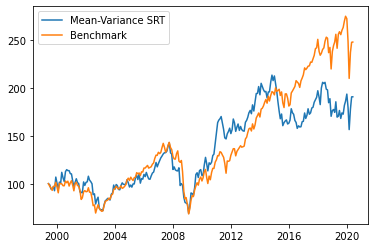

In [53]:
plt.plot(port1)
plt.plot(bnch)
plt.legend(["Mean-Variance SRT","Benchmark"])
plt.show()

### Performance

In [54]:
ret_port = np.diff(port1)/port1[:-1]
ret_bnch = np.diff(bnch)/bnch[:-1]

In [55]:
print(np.mean(ret_port), np.mean(ret_bnch))

0.003871050578358261 0.004561304686898123


In [56]:
print(np.std(ret_port), np.std(ret_bnch))

0.05099728600329729 0.04309445210215034


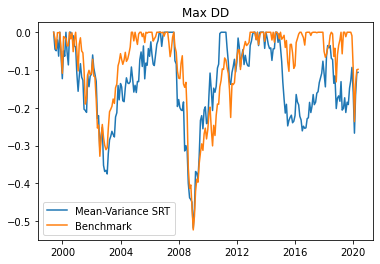

In [62]:
plt.plot(DD(np.diff(port1)/port1[:-1]), label='Mean-Variance SRT')
plt.plot(DD(np.diff(bnch)/bnch[:-1]), label='Benchmark')
plt.legend()
plt.title("Max DD")
plt.show()

In [58]:
print(np.min(DD(np.diff(port1)/port1[:-1])), np.min(DD(np.diff(bnch)/bnch[:-1])))

-0.5183022330848601 -0.5229911488243363


In [59]:
sharpe_port = np.mean(ret_port-rf) / np.std(ret_port-rf)
sharpe_bnch = np.mean(ret_bnch-rf) / np.std(ret_bnch-rf)
print(sharpe_port,sharpe_bnch)

0.04716786840514107 0.07171165872024043


In [60]:
info = np.mean(ret_port-ret_bnch)/np.std(ret_port-ret_bnch)
info

-0.019398421703025547

In [61]:
cal_port = -np.mean(ret_port-rf)/np.min(DD(ret_port))
cal_bnch = -np.mean(ret_bnch-rf)/np.min(DD(ret_bnch))
print(cal_port,cal_bnch)

0.00464859524836448 0.0059267377917249535
